In [1]:
import os
import cv2
import torch
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
FILE_PATH= "/kaggle/input/shop-lifter/Shop DataSet/non shop lifters/shop_lifter_n_0.mp4" # Example to test functions
video_path = '/kaggle/input/shop-lifter/Shop DataSet'  # Path to your dataset
class_0 = "non shop lifters"
class_1 = "shop lifters"
# Parameters
             # Number of frames to extract from each video
height, width = 90, 90        # Dimensions to resize each frame
channels = 3                  # Number of channels (RGB)
batch_size = 2           # Batch size for training
epochs = 30                   # Number of training epochs

In [12]:
all_videos = []
for label, class_name in enumerate(os.listdir(video_path)):
    class_path = os.path.join(video_path, class_name)
    if os.path.isdir(class_path):
        for video_name in os.listdir(class_path):
            video_file = os.path.join(class_path, video_name)
            if video_file.endswith('.mp4'):  # Adjust for your video format
                all_videos.append((video_file, label))



Total videos: 855
Training videos: 684
Testing videos: 171


In [48]:
# Define augmentation functions
def random_flip(frames):
    """Flip video frames horizontally with a 50% chance."""
    
    return [cv2.flip(frame, 0) for frame in frames]
    

def random_rotation(frames):
    """Rotate frames by a random angle between -10 and 10 degrees."""
    angle = random.uniform(-10, 10)
    height, width = frames[0].shape[:2]
    M = cv2.getRotationMatrix2D((width//2, height//2), angle, 1)
    return [cv2.warpAffine(frame, M, (width, height)) for frame in frames]

def random_crop(frames, crop_size):
    """Randomly crop the video frames."""
    height, width = frames[0].shape[:2]
    crop_height, crop_width = crop_size
    x = random.randint(0, width - crop_width)
    y = random.randint(0, height - crop_height)
    return [frame[y:y+crop_height, x:x+crop_width] for frame in frames]

def frame_skip(frames, skip_step=2):
    """Skip frames to reduce the frame rate."""
    return frames[::skip_step]

def adjust_brightness(frames, factor=1.5):
    """Randomly adjust brightness by a factor between 0.5 and 1.5."""
    factor = random.uniform(0.5, 1.5)
    return [cv2.convertScaleAbs(frame, alpha=factor, beta=0) for frame in frames]



In [54]:
# Example function to apply augmentations to a video
def augment_video(frames):
    """Apply a random combination of augmentations to video frames."""
    frames = random_flip(frames)
    frames = random_rotation(frames)
    frames = random_crop(frames, crop_size=(height, 20))  # Change crop size as needed
    frames = frame_skip(frames)
    frames = adjust_brightness(frames)
    return frames

In [ ]:
import datetime

for video,label in gen:
    # Perform data augmentation on the frames
    for video in videos:
        video = np.array(video)
        augmented_frames = augment_video(video)
        # Optionally, save the augmented video
        out = cv2.VideoWriter(f'{str(datetime.datetime.now())}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (width, height))
        print(out)
        #         all_videos.append((out,label))
        
        for frame in augmented_frames:
            out.write(frame)
        out.release()
        break

In [ ]:
# Split into training and testing sets
train_videos, test_videos = train_test_split(all_videos, test_size=0.2, stratify=[label for _, label in all_videos], random_state=42)

print(f"Total videos: {len(all_videos)}")
print(f"Training videos: {len(train_videos)}")
print(f"Testing videos: {len(test_videos)}")

In [3]:
def count_frames(video_path):
    """Count the number of frames in a video file."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file {video_path}")
        return 0
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count

In [4]:
def average_frames(video_dir):
    """Calculate the average number of frames for all videos in the specified directory."""
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]
    total_frames = 0
    video_count = 0
    
    for video_file in video_files:
        video_path = os.path.join(video_dir, video_file)
        frame_count = count_frames(video_path)
        if frame_count > 0:  # Ensure valid frame count
            total_frames += frame_count
            video_count += 1

    # Calculate average
    average = total_frames / video_count if video_count > 0 else 0
    return average


In [5]:
# Path to your dataset
avg_frames_0 = average_frames(os.path.join(video_path,class_0))
print(f"Average number of frames per video in class 0: {avg_frames_0:.2f}")

Average number of frames per video in class 0: 347.78


In [6]:
# Path to your dataset
avg_frames_1 = average_frames(os.path.join(video_path,class_1))
print(f"Average number of frames per video in class 1: {avg_frames_1:.2f}")

Average number of frames per video in class 1: 304.60


In [7]:
Total_frames_average  = (avg_frames_0  + avg_frames_1) //2
Total_frames_average

326.0

In [8]:
num_frames = int(Total_frames_average * .8 )
# num_frames = int(Total_frames_average)

In [9]:
class_names = []
video_counts = []
for label, class_name in enumerate(os.listdir(video_path)):
    class_path = os.path.join(video_path, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory (class folder)
        class_names.append(class_name)
        video_counts.append(len(os.listdir(class_path)))
        

In [10]:
label = []
for i, loops in enumerate(video_counts):
    for j in range(loops):
        label.append(i)
print(len(label))    

855


In [11]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)

# Convert to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict) 

{0: 0.8050847457627118, 1: 1.3194444444444444}


In [13]:
def video_generator(videos, batch_size, num_frames, height, width, channels, class_weights):
    """Generator function to yield video batches with class weights from pre-defined video list."""
    while True:  # Loop indefinitely
        random.shuffle(videos)  # Shuffle the videos for each epoch

        data = []
        labels = []
        weights = []

        # Iterate through the shuffled list of videos
        for video_file, label in videos:
            frames = []
            cap = cv2.VideoCapture(video_file)

            if not cap.isOpened():
                print(f"Error opening video file {video_file}")
                continue

            frame_count = 0
            # Read frames from the video
            while cap.isOpened() and frame_count < num_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                # Resize frame and append to the frames list
                frame = cv2.resize(frame, (width, height))
                frame = frame.astype('float32') / 255.0
                frames.append(frame)
                frame_count += 1
            
            cap.release()

            # If the video has fewer frames than required, pad with zeros
            while len(frames) < num_frames:
                frames.append(np.zeros((height, width, channels), dtype=np.uint8))

            # Convert frames list to numpy array
            frames = np.array(frames)
            if augment:
                frames = augment_video(frames)
            # Append the processed video, its label, and the corresponding weight
            data.append(frames)
            labels.append(label)
#             weights.append(class_weights[label])  # Use class_weights

            # Yield batch of videos when data list reaches batch_size
            if len(data) == batch_size:
#                 yield np.array(data), np.array(labels), np.array(weights)
                yield np.array(data), np.array(labels)
                data = []  # Reset data list for the next batch
                labels = []  # Reset labels list for the next batch
#                 weights = []  # Reset weights list for the next batch

        # If there are leftover videos that don't fill a full batch, yield them
        if len(data) > 0:
#             yield np.array(data), np.array(labels), np.array(weights)
            yield np.array(data), np.array(labels)


In [14]:
# Create the generators
gen = video_generator(train_videos, batch_size, num_frames, height, width, channels, class_weights)
test_gen = video_generator(test_videos, batch_size, num_frames, height, width, channels, class_weights)

In [15]:
for batch in gen:
    videos , labels = batch
    print(videos.shape)
    print(labels)
#     print(weights)
    break

(2, 260, 90, 90, 3)
[0 1]


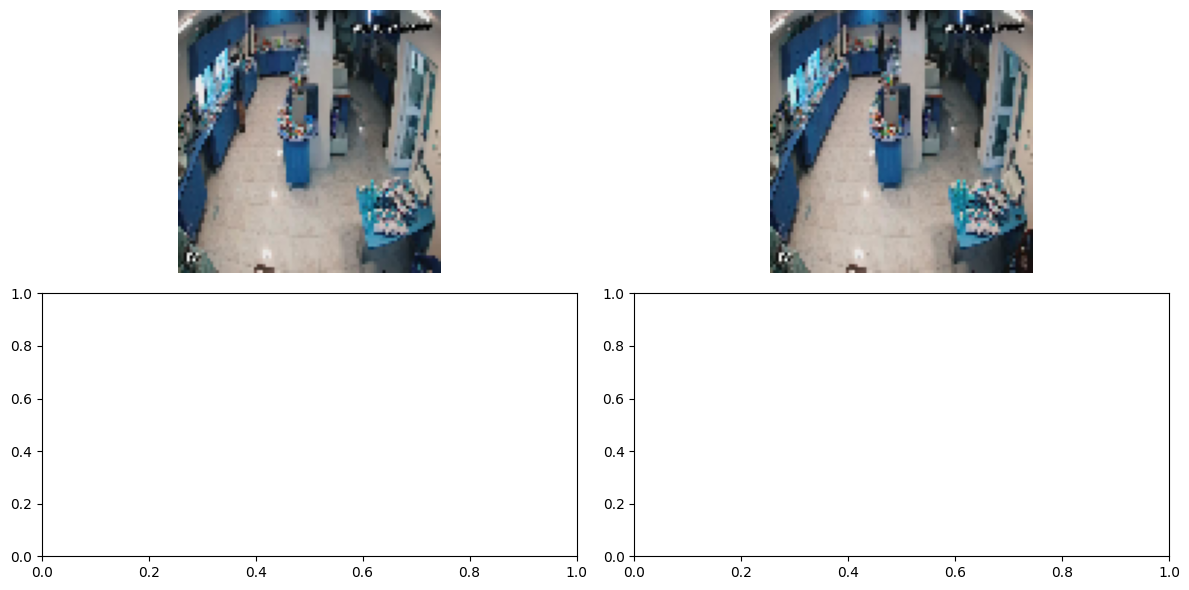

In [16]:

def plot_images(video_list):
    """Plot a list of 8 images in a 2x2 grid."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))  
    axes = axes.flatten()  
    
    for i, video in enumerate(video_list):
        axes[i].imshow(video[20,:,:,:])
        axes[i].axis('off')  

    plt.tight_layout()
    plt.show()


plot_images(videos)


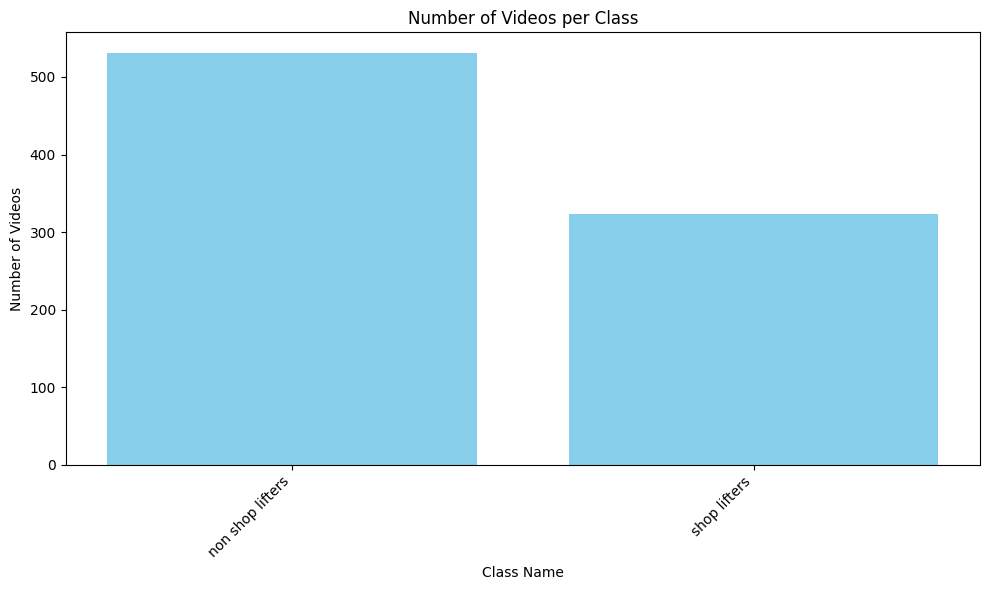

In [17]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(class_names, video_counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Videos')
plt.title('Number of Videos per Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
video_counts

[531, 324]

## Video Augmentation

In [22]:
# augmented_video.shape

In [23]:
# plt.imshow(augmented_video[:,:,:,50])
# plt.axis('off')  # Hide axis
# plt.show()

## 3DCNN Model

In [24]:
import tensorflow as tf

In [25]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [26]:
from tensorflow.keras import backend as K

# Clear the session to release memory
K.clear_session()

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [28]:

model = tf.keras.Sequential([
        tf.keras.layers.Conv3D(8, (3, 3, 3), activation='relu', input_shape=(num_frames, height, width, channels)),
        tf.keras.layers.MaxPooling3D((1, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv3D(16, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((1, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((1, 2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling3D(),
#         tf.keras.layers.Dense(128, activation='relu'), 
#         tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Dense(32, activation='relu'), 
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 3DCNN-RNN Model

In [29]:
# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 258, 88, 88, 8) │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 258, 44, 44, 8) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 258, 44, 44, 8) │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 256, 42, 42,    │         3,472 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 256, 21, 21,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 21, 21,    │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 254, 19, 19,    │        13,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 254, 9, 9, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 254, 9, 9, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,330 (75.51 KB)

 Trainable params: 19,218 (75.07 KB)

 Non-trainable params: 112 (448.00 B)

In [31]:
# Fit the model using the generators
steps_per_epoch = len(train_videos) // batch_size
validation_steps = len(test_videos) // batch_size

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('ShopLifter.keras',
    monitor='val_loss', 
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

callbacks = [early_stopping,lr_scheduler,checkpoint]

In [33]:
tf.get_logger().setLevel('ERROR')  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [34]:
#  Train the model
hist = model.fit(
                gen,
                steps_per_epoch=steps_per_epoch,
                epochs=20,
                validation_data=test_gen,
                validation_steps=validation_steps,
                batch_size=batch_size,
                callbacks = callbacks)

Epoch 1/20


I0000 00:00:1727336087.943036    3529 service.cc:145] XLA service 0x7a71cc2118c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727336087.943112    3529 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/342 ━━━━━━━━━━━━━━━━━━━━ 35s 105ms/step - accuracy: 0.6250 - loss: 0.7043  

I0000 00:00:1727336096.292470    3529 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.6265 - loss: 0.6706
Epoch 1: val_loss improved from inf to 0.64790, saving model to ShopLifter.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 195s 541ms/step - accuracy: 0.6265 - loss: 0.6706 - val_accuracy: 0.6235 - val_loss: 0.6479 - learning_rate: 1.0000e-04
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7030 - loss: 0.6311
Epoch 2: val_loss improved from 0.64790 to 0.47314, saving model to ShopLifter.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 182s 534ms/step - accuracy: 0.7031 - loss: 0.6311 - val_accuracy: 0.8402 - val_loss: 0.4731 - learning_rate: 1.0000e-04
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7700 - loss: 0.5490
Epoch 3: val_loss did not improve from 0.47314
342/342 ━━━━━━━━━━━━━━━━━━━━ 182s 533ms/step - accuracy: 0.7700 - loss: 0.5490 - val_accuracy: 0.4142 - val_loss: 0.7617 - learning_rate: 1.0000e-04
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7572 - loss: 0.5471

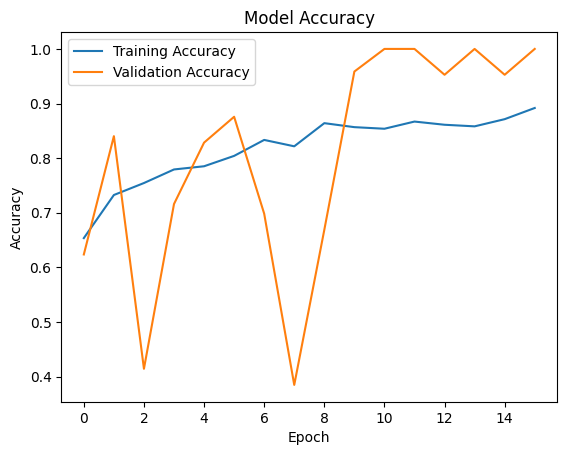

In [35]:
# Plot the accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

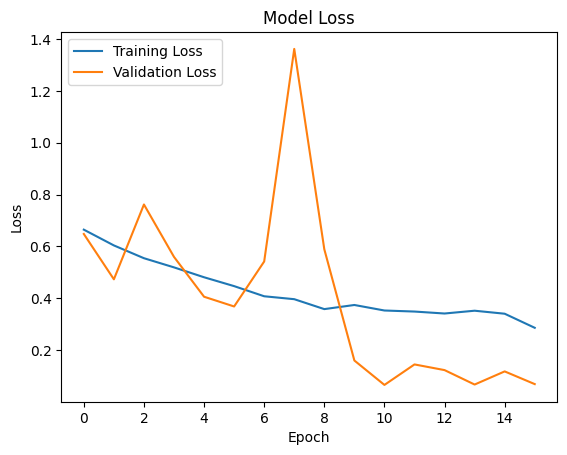

In [36]:
# Plot the loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 10)
plt.legend(loc='upper left')
plt.show()

In [37]:
# Save the model
model.save('shop_lifter_model.h5')